# Diffusion mapping tutorial

Start by importing the required libraries and defining some settings:

In [2]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

from ukat.data import fetch
from ukat.mapping.diffusion import ADC, DTI
from MDR import MDR, Tools
import ukat.moco.mdr_functions as mdr_functions

# Ensure figures are rendered in the notebook
%matplotlib inline

# Initialise output path for the Model-Driven Registration process
directory = 'diffusion_motion_correction_output'
os.makedirs(directory, exist_ok=True)
OUTPUT_DIR = os.path.join(os.getcwd(), directory)

In [3]:
# Fetch test data
pixel_array, affine, bvals, bvecs = fetch.dwi_philips()

In [6]:
# Pre-processing as preparation for the Model-Driven Registration process
pixel_spacing = (np.linalg.norm(affine[:3, 1]), np.linalg.norm(affine[:3, 0]))
elastix_model_parameters = Tools.read_elastix_model_parameters("../ukat/moco/BSplines_DWI.txt")
list_input_parameters = [affine, bvals, None, False]

In [8]:
# Model-driven registration
mdr_output = MDR.model_driven_registration(pixel_array, pixel_spacing, mdr_functions, list_input_parameters, elastix_model_parameters, precision=3, function='DWI_Moco')
moco_array = mdr_output[0]

ValueError: cannot reshape array of size 11649024 into shape (16384,9)

In [ ]:
# Save motion corrected diffusion sequence to NIfTI
moco_nifti = nib.Nifti1Image(moco_array, affine=affine)
nib.save(moco_nifti, os.path.join(OUTPUT_DIR ,'DWI_motion_corrected.nii.gz'))

In [ ]:
# Generate a mask based on the intensity of the b0 volume. This will reduce computation times.
mask = pixel_array[..., 0] > 20000

# Calculate maps from the original diffusion sequence using ADC methods and save as niftis
adc_mapper = ADC(pixel_array, affine, bvals, mask=mask, ukrin_b=True)
adc_mapper.to_nifti(output_directory=OUTPUT_DIR, base_file_name='diffusion_original', maps='all')

# Calculate maps from the original diffusion sequence using DTI methods and save as niftis
dti_mapper = DTI(pixel_array, affine, bvals, bvecs, mask=mask, ukrin_b=True)
dti_mapper.to_nifti(output_directory=OUTPUT_DIR, base_file_name='diffusion_original', maps=['md', 'fa'])

# Calculate maps from the motion corrected diffusion sequence using ADC methods and save as niftis
adc_mapper = ADC(moco_array, affine, bvals, mask=mask, ukrin_b=True)
adc_mapper.to_nifti(output_directory=OUTPUT_DIR, base_file_name='diffusion_moco', maps='all')

# Calculate maps from the motion corrected diffusion sequence using DTI methods and save as niftis
dti_mapper = DTI(moco_array, affine, bvals, bvecs, mask=mask, ukrin_b=True)
dti_mapper.to_nifti(output_directory=OUTPUT_DIR, base_file_name='diffusion_moco', maps=['md', 'fa'])

100%|██████████| 57520/57520 [00:07<00:00, 7510.89it/s]


(-0.5, 127.5, 127.5, -0.5)

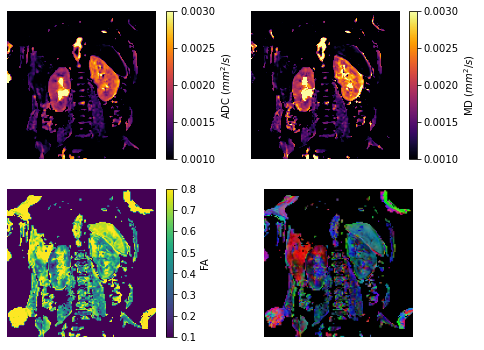

In [ ]:
# Display the central slice of each map
fig, ax = plt.subplots(2, 2, figsize=(8, 6))

# Display a central slice of the ADC map
im = ax[0, 0].imshow(np.rot90(adc_mapper.adc[:, :, adc_mapper.shape[2]//2]), cmap='inferno', clim=(0.001, 0.003))
cb = fig.colorbar(im, ax=ax[0, 0])
cb.set_label('ADC ($mm^2/s$)')
ax[0, 0].axis('off')

# Display a central slice of the MD map
im = ax[0, 1].imshow(np.rot90(dti_mapper.md[:, :, dti_mapper.shape[2]//2]), cmap='inferno', clim=(0.001, 0.003))
cb = fig.colorbar(im, ax=ax[0, 1])
cb.set_label('MD ($mm^2/s$)')
ax[0, 1].axis('off')

# Display a central slice of the FA map
im = ax[1, 0].imshow(np.rot90(dti_mapper.fa[:, :, dti_mapper.shape[2]//2]), cmap='viridis', clim=(0.1, 0.8))
cb = fig.colorbar(im, ax=ax[1, 0])
cb.set_label('FA')
ax[1, 0].axis('off')

# Display a central slice of the color FA map
im = ax[1, 1].imshow(np.rot90(dti_mapper.color_fa[:, :, dti_mapper.shape[2]//2, :]))
ax[1, 1].axis('off')